In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import Conv2D , MaxPool2D , BatchNormalization,Dropout,Flatten,Dense,ReLU
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
img_size = 150

Using TensorFlow backend.


In [ ]:
local_zip = '/content/drive/My Drive/Zipped file/Train_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/Train')
local_zip = '/content/drive/My Drive/Zipped file/Test_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/Test')
zip_ref.close()

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   #rotation_range = 40,
                                   #width_shift_range = 0.2,
                                   #height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(
    rescale=1/255
   )

train_generator = train_datagen.flow_from_directory(
        '/tmp/Train/Train', 
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        '/tmp/Test/Test',
        target_size=(150, 150), 
        batch_size=16,
       
        class_mode='categorical')

Found 14708 images belonging to 7 classes.
Found 591 images belonging to 7 classes.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  

--2020-06-08 18:02:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   149MB/s    in 0.6s    

2020-06-08 18:02:14 (149 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed8')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 1280)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (7, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])




In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.98):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
#callbacks = myCallback()
#checkpoint = ModelCheckpoint('/tmp/Pre_trained_model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
'''checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history = model.fit(
      train_generator,
      steps_per_epoch=50,  
      epochs=30,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=16,
      callbacks=[model_checkpoint_callback]
      )'''
checkpoint = ModelCheckpoint('model-{epoch:02d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

history=model.fit(train_data,train_target,epochs=10,callbacks=[checkpoint],validation_split=0.2)

In [ ]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Uploading the file in the form of numpy

---



---



In [ ]:
local_zip = '/content/drive/My Drive/Zipped file/Images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/Images')

zip_ref.close()

In [ ]:
import cv2
data_path='/tmp/Images/Images'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'Premature Ventricular Contraction': 0, 'Right Bundle Branch Block': 1, 'Atrial Premature Contraction': 2, 'Paced Beat': 3, 'Ventricular Escape Beat': 4, 'Normal': 5, 'Left Bundle Branch Block': 6}
['Premature Ventricular Contraction', 'Right Bundle Branch Block', 'Atrial Premature Contraction', 'Paced Beat', 'Ventricular Escape Beat', 'Normal', 'Left Bundle Branch Block']
[0, 1, 2, 3, 4, 5, 6]


In [ ]:
img_size=150
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [ ]:

data=np.array(data)/255.0
print(data.shape)
data=np.reshape(data,(data.shape[0],img_size,img_size,1))

print(data.shape)

target=np.array(target)

new_target=np_utils.to_categorical(target)
print(new_target.shape)
#np.save('/tmp/data',data)
#np.save('/tmp/target',new_target)

(15275, 150, 150)
(15275, 150, 150, 1)
(15275, 7)


In [ ]:
np.save('/tmp/data',data)
np.save('/tmp/target',new_target)

In [ ]:
data=np.load('/tmp/data.npy')
target=np.load('/tmp/target.npy')

In [ ]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [ ]:
train_data.shape

(13747, 150, 150, 1)

In [ ]:
test_data.shape

(1528, 150, 150, 1)

In [ ]:
IMAGE_SIZE = 150
model = Sequential()

model.add(Conv2D(64, (3,3),strides = (1,1), input_shape = data.shape[1:],kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Conv2D(64, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides= (2,2)))

model.add(Conv2D(128, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Conv2D(128, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides= (2,2)))

model.add(Conv2D(256, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Conv2D(256, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides= (2,2)))

model.add(Flatten())

model.add(Dense(2048))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
pwd

'/content'

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:02d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

history=model.fit(train_data,train_target,epochs=10,callbacks=[checkpoint],validation_split=0.2)

Train on 10997 samples, validate on 2750 samples
Epoch 1/10
10997/10997 [==============================] - 66s 6ms/step - loss: 0.0153 - accuracy: 0.9970 - val_loss: 42.9266 - val_accuracy: 0.2516
Epoch 2/10
10997/10997 [==============================] - 64s 6ms/step - loss: 0.0108 - accuracy: 0.9973 - val_loss: 0.1048 - val_accuracy: 0.9916
Epoch 3/10
10997/10997 [==============================] - 64s 6ms/step - loss: 0.0159 - accuracy: 0.9970 - val_loss: 9.6164 - val_accuracy: 0.7676
Epoch 4/10
10997/10997 [==============================] - 64s 6ms/step - loss: 0.0102 - accuracy: 0.9981 - val_loss: 47.1358 - val_accuracy: 0.5822
Epoch 5/10
10997/10997 [==============================] - 64s 6ms/step - loss: 0.0077 - accuracy: 0.9981 - val_loss: 565.5245 - val_accuracy: 0.0578
Epoch 6/10
10997/10997 [==============================] - 64s 6ms/step - loss: 0.0172 - accuracy: 0.9969 - val_loss: 23.6581 - val_accuracy: 0.7000
Epoch 7/10
10997/10997 [==============================] - 64s 6m

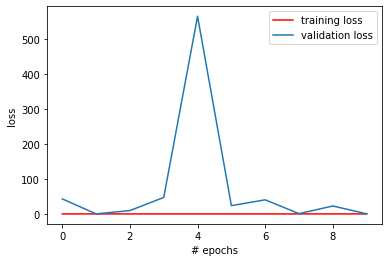

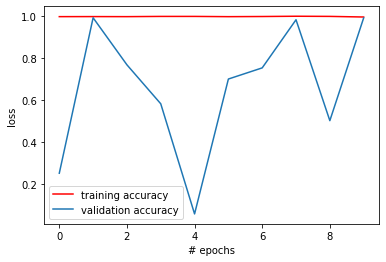

In [ ]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
print(model.evaluate(test_data,test_target))

 736/1528 [=============>................] - ETA: 1s

In [ ]:
model = load_model('model-14.model')
labels_dict={0:'Left Bundle Branch Block',1:'Paced Beat',2:'Ventricular Escape Beat',3:'Right Bundle Branch Block',4:'Normal',5:'Atrial Premature Contraction',6:'Premature Ventricular Contraction'}
#{'Left Bundle Branch Block': 0, 'Paced Beat': 1, 'Ventricular Escape Beat': 2, 'Right Bundle Branch Block': 3, 'Normal': 4, 'Atrial Premature Contraction': 5, 'Premature Ventricular Contraction': 6}

**Testing the model with the images uploaded form outside**

In [ ]:
img=cv2.imread('/4111.png')
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

resized=cv2.resize(gray,(img_size,img_size))

normalized=resized/255.0
reshaped=np.reshape(normalized,(1,150,150,1))
result=model.predict(reshaped)
print(result)
label=np.argmax(result,axis=1)[0]
print(labels_dict[label])     


[[7.7547212e-11 1.4784619e-12 7.9075740e-16 8.8187904e-13 2.8300391e-08
  1.0000000e+00 1.6903284e-12]]
Atrial Premature Contraction
